In [21]:
import numpy as np
import pytesseract
import cv2
import matplotlib.pyplot as plt

In [17]:

img = cv2.imread('image.jpg')

# get grayscale image
def get_grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# noise removal
def remove_noise(image):
    return cv2.medianBlur(image,5)
 
#thresholding
def thresholding(image):
    return cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

#dilation
def dilate(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.dilate(image, kernel, iterations = 1)
    
#erosion
def erode(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.erode(image, kernel, iterations = 1)

#opening - erosion followed by dilation
def opening(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)

#canny edge detection
def canny(image):
    return cv2.Canny(image, 100, 200)

#skew correction
def deskew(image):
    coords = np.column_stack(np.where(image > 0))
    angle = cv2.minAreaRect(coords)[-1]
    if angle < -45:
        angle = -(90 + angle)
    else:
        angle = -angle
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    return rotated

#template matching
def match_template(image, template):
    return cv2.matchTemplate(image, template, cv2.TM_CCOEFF_NORMED) 

In [10]:
def get_edges_and_crop_roi(img, threshold=0.1):
    """
    Extracts the edges of an image and crops the ROI based on a threshold.

    Args:
        img (np.ndarray): The input image.
        threshold (float, optional): The threshold value for edge detection. Defaults to 0.1.

    Returns:
        tuple: A tuple containing the cropped ROI and the original image with edges highlighted.

    Raises:
        ValueError: If the input image is not a grayscale image.
    """

    if len(img.shape) != 2:
        raise ValueError("Input image must be a grayscale image.")

    # Apply Canny edge detection
    edges = cv2.Canny(img, 50, 150)

    # Find non-zero edge pixels
    non_zero_points = np.argwhere(edges > 0)

    # Find minimum and maximum points for each axis
    min_y, min_x = np.min(non_zero_points, axis=0)
    max_y, max_x = np.max(non_zero_points, axis=0)

    # Crop the ROI based on the edge boundaries
    cropped_roi = img[min_y:max_y + 1, min_x:max_x + 1]

    # Highlight edges on the original image (optional)
    img_with_edges = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)  # Convert to BGR for color
    img_with_edges[edges > 0] = [0, 0, 255]  # Highlight edges in blue

    return cropped_roi, img_with_edges

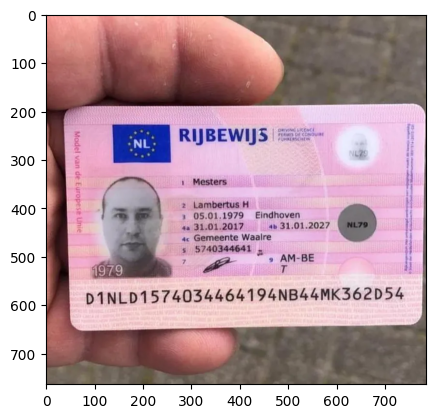

In [22]:
img_path = "data/id_2.png"  # Replace with the correct path to your image

img = cv2.imread(img_path)

# if img is None:
#     print("Error: Image not found at the specified path.")
# else:
#     # Convert BGR image to RGB for Matplotlib
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Display the image using Matplotlib
plt.imshow(img_rgb)
plt.show()

In [3]:
# # Alternatively, display using OpenCV (close manually)
# cv2.imshow("ID Card", img)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

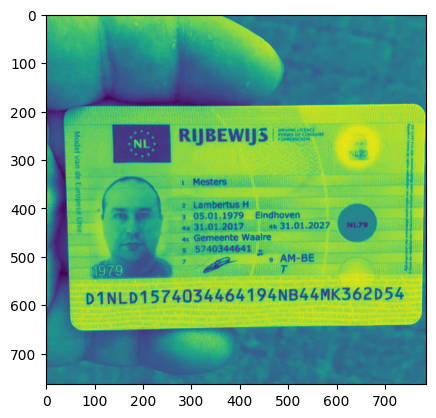

In [4]:
gray_img = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
plt.imshow(gray_img)
plt.show()

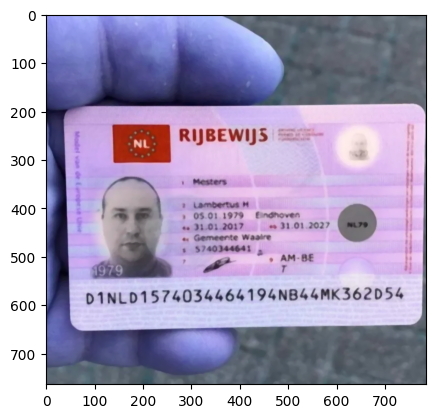

In [5]:
denoised_img = cv2.medianBlur(img, 5)

plt.imshow(denoised_img)

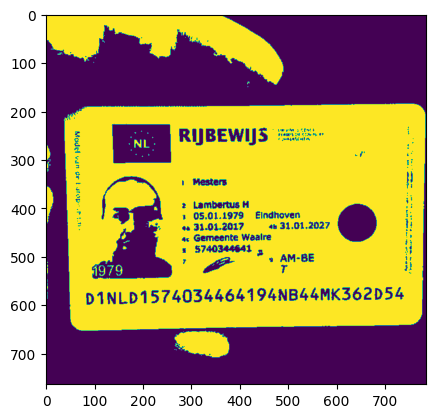

In [9]:
binary_img = cv2.threshold(gray_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
plt.imshow(binary_img)

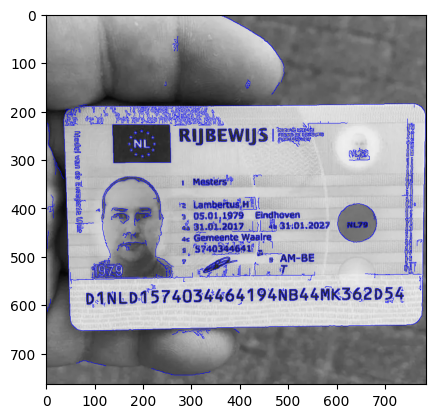

In [12]:
x, y = get_edges_and_crop_roi(gray_img)

plt.imshow(y)

In [23]:
def extract_id_card(img):
    """
    Extracts the ID card from an image containing a hand.

    Args:
        img (np.ndarray): The input image.

    Returns:
        np.ndarray: The cropped image containing the ID card, or None if no ID card is detected.
    """

    # Convert image to grayscale
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Apply adaptive thresholding to separate foreground (including ID card) from background
    thresh = cv2.adaptiveThreshold(gray_img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 2)

    # Find contours in the thresholded image
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Select the largest contour (assuming the ID card is the largest object)
    largest_contour = None
    largest_area = 0
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area > largest_area:
            largest_contour = cnt
            largest_area = area

    # If no large contour is found, assume no ID card is present
    if not largest_contour.any():
        return None

    # Get bounding rectangle of the largest contour
    x, y, w, h = cv2.boundingRect(largest_contour)

    # Apply additional filtering (optional):
    # - Apply bilateral filtering for noise reduction
    # filtered_img = cv2.bilateralFiltering(img[y:y+h, x:x+w], 9, 75, 75)
    # - Morphological operations (e.g., erosion, dilation) for shape refinement

    return img[y:y+h, x:x+w]

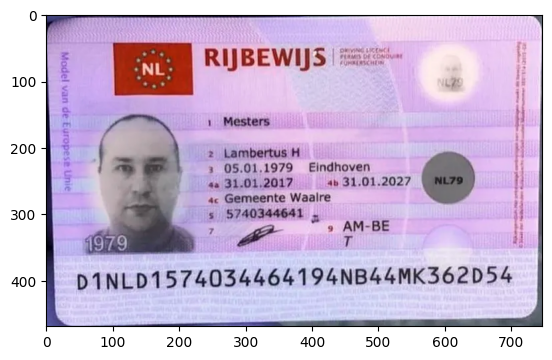

In [24]:
x = extract_id_card(img)

plt.imshow(x)

In [25]:
def deskew_image(image):
    """
    Corrects skew in an image using the minimum enclosing rectangle method.

    Args:
        image (np.ndarray): The input image (grayscale).

    Returns:
        np.ndarray: The deskewed image (grayscale), or None if no non-zero pixels are found.

    Raises:
        ValueError: If the input image is not grayscale.
    """

    if len(image.shape) != 2:
        raise ValueError("Input image must be a grayscale image.")

    # Find non-zero pixel coordinates
    coords = np.column_stack(np.where(image > 0))

    # Handle empty input gracefully
    if not coords.any():
        return None  # Return None or any appropriate default if no valid points

    # Ensure correct data type (float32 for consistency)
    coords = coords.astype(np.float32)

    # Calculate the angle of the minimum enclosing rectangle
    angle = cv2.minAreaRect(coords)[-1]

    # Adjust the angle to ensure it's within -90 to 90 degrees
    if angle < -45:
        angle = -(90 + angle)
    else:
        angle = -angle

    # Get image dimensions and center coordinates
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)

    # Create rotation matrix using getRotationMatrix2D
    M = cv2.getRotationMatrix2D(center, angle, 1.0)

    # Apply affine transformation using warpAffine with interpolation and border handling
    deskewed_image = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)

    return deskewed_image


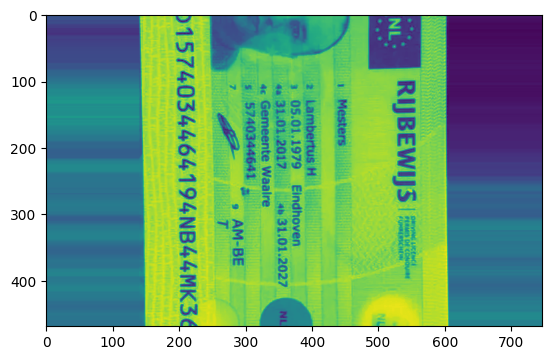

In [27]:
y = deskew_image(get_grayscale(x))

plt.imshow(y)

In [31]:
def deskew_and_align_image(image, margin_width=10, margin_height=10):
    """
    Corrects skew in an image using the minimum enclosing rectangle method,
    aligns it horizontally and vertically with specified margins, and avoids unnecessary rotation.

    Args:
        image (np.ndarray): The input image (grayscale).
        margin_width (int, optional): The desired horizontal margin. Defaults to 10.
        margin_height (int, optional): The desired vertical margin. Defaults to 10.

    Returns:
        np.ndarray: The deskewed and aligned image (grayscale), or None if no non-zero pixels are found.

    Raises:
        ValueError: If the input image is not grayscale.
    """

    if len(image.shape) != 2:
        raise ValueError("Input image must be a grayscale image.")

    # Find non-zero pixel coordinates
    coords = np.column_stack(np.where(image > 0))

    # Handle empty input gracefully
    if not coords.any():
        return None

    # Ensure correct data type (float32 for consistency)
    coords = coords.astype(np.float32)

    # Calculate the angle of the minimum enclosing rectangle
    angle = cv2.minAreaRect(coords)[-1]

    # Check if absolute angle is greater than a threshold (e.g., 45 degrees) to avoid unnecessary rotation
    if abs(angle) <= 45:
        # Skip rotation if angle is minimal
        new_angle = 0
    else:
        # Adjust the angle to ensure it's within -90 to 90 degrees
        if angle < -45:
            new_angle = -(90 + angle)
        else:
            new_angle = -angle

    # Get image dimensions and center coordinates
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)

    # Create rotation matrix using getRotationMatrix2D with the adjusted angle
    M = cv2.getRotationMatrix2D(center, new_angle, 1.0)

    # Apply affine transformation using warpAffine with interpolation and border handling
    deskewed_image = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)

    # Calculate minimum and maximum bounding rectangle coordinates
    min_x, min_y = np.min(coords, axis=0)
    max_x, max_y = np.max(coords, axis=0)

    # Add margins to bounding rectangle
    new_min_x = max(0, min_x - margin_width)
    new_max_x = min(w, max_x + margin_width)
    new_min_y = max(0, min_y - margin_height)
    new_max_y = min(h, max_y + margin_height)

    # Extract and return the aligned ROI
    aligned_image = deskewed_image[int(new_min_y):int(new_max_y), int(new_min_x):int(new_max_x)]
    return aligned_image


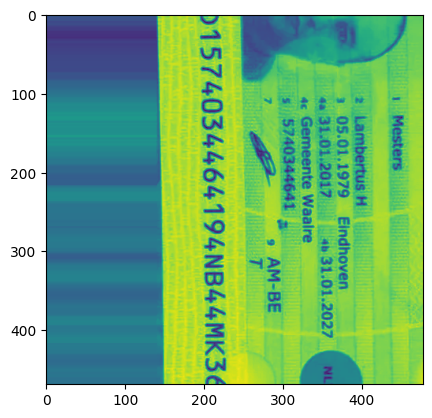

In [32]:
dskew = deskew_and_align_image(get_grayscale(x))

plt.imshow(dskew)

In [33]:
def align_image(image, margin_width=10, margin_height=10):
    """
    Aligns an image horizontally and vertically with specified margins,
    avoiding rotations and handling cases with no content.

    Args:
        image (np.ndarray): The input image (grayscale).
        margin_width (int, optional): The desired horizontal margin. Defaults to 10.
        margin_height (int, optional): The desired vertical margin. Defaults to 10.

    Returns:
        np.ndarray: The aligned image (grayscale), or None if no non-zero pixels are found.

    Raises:
        ValueError: If the input image is not grayscale.
    """

    if len(image.shape) != 2:
        raise ValueError("Input image must be a grayscale image.")

    # Find non-zero pixel coordinates
    coords = np.column_stack(np.where(image > 0))

    # Handle empty input gracefully
    if not coords.any():
        return None

    # Get image dimensions
    (h, w) = image.shape[:2]

    # Calculate minimum and maximum bounding rectangle coordinates
    min_x, min_y = np.min(coords, axis=0)
    max_x, max_y = np.max(coords, axis=0)

    # Add margins to bounding rectangle
    new_min_x = max(0, min_x - margin_width)
    new_max_x = min(w, max_x + margin_width)
    new_min_y = max(0, min_y - margin_height)
    new_max_y = min(h, max_y + margin_height)

    # Extract and return the aligned ROI
    aligned_image = image[int(new_min_y):int(new_max_y), int(new_min_x):int(new_max_x)]
    return aligned_image

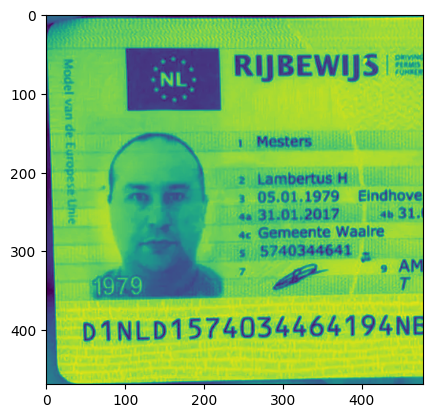

In [34]:
aligned_img = align_image(get_grayscale(x))

plt.imshow(aligned_img)